## Big data analytics: Big Data Bowl 
Authored by Jason Maloney and Jesse Pezzillo

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings; warnings.simplefilter('ignore')

In [2]:
# This dataset can be downloaded from https://www.kaggle.com/c/nfl-big-data-bowl-2020/data after an agreement is digitally signed through kaggle. 
data = pd.read_csv('train.csv')
#lower all columns
data.columns = map(str.lower, data.columns)

#### View the data and types

In [ ]:
print(data.dtypes)

In [ ]:
data.head()

#### Player height

In [3]:
# create function to convert playerHeight to inches
def heightToInches(x):
    try:
        x,x1 = x.split('-')
        x = int(x)
        x1 = int(x1)
        x = (12*x) + x1
        return(x)
    except:
        return int(x*12)

In [4]:
# run function over column
data["playerheight"] = data["playerheight"].apply(heightToInches)

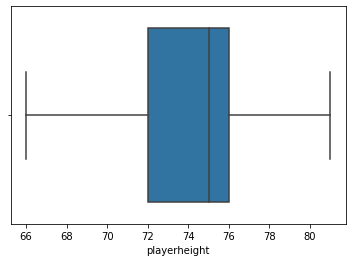

In [5]:
sns.boxplot(data["playerheight"])
plt.show()

#### Player age

In [6]:
# convert TimeHandoff to dates and times
data['timehandoff'] = pd.to_datetime(data['timehandoff'])
data['timesnap'] = pd.to_datetime(data['timesnap'])
data['playerbirthdate'] = pd.to_datetime(data["playerbirthdate"])
# confirm dtype
print('handoff time:',data["timehandoff"].dtype)
print('snap time:',data["timesnap"].dtype)
print('playerbirthdate',data["playerbirthdate"].dtype)

handoff time: datetime64[ns, UTC]
snap time: datetime64[ns, UTC]
playerbirthdate datetime64[ns]


In [7]:
# generate age of each player
def birthDayCalc(df):
    birthDay = df[0].year
    timeHandoff = df[1].year
    age = (timeHandoff - birthDay) 
    return age
data["age"] = data[["playerbirthdate","timehandoff"]].apply(birthDayCalc, axis=1)

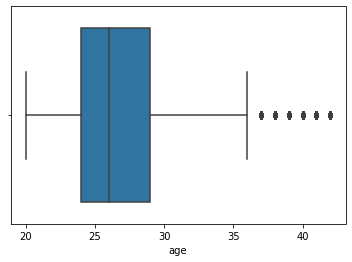

Player anomolies/Old dudes:


array(['Tom Brady', 'Josh McCown', 'Benjamin Watson', 'James Harrison',
       'Carson Palmer', 'Julius Peppers', 'Drew Brees', 'Terence Newman',
       'Antonio Gates', 'Dwight Freeney', 'Mike Adams', 'Philip Rivers',
       'Karlos Dansby', 'Eli Manning', 'Andrew Whitworth', 'Matt Schaub',
       'Cameron Wake', 'Ryan Fitzpatrick', 'Jason Peters',
       'Terrell Suggs', 'Jason Witten', 'Ben Roethlisberger'],
      dtype=object)

In [8]:
sns.boxplot(data["age"])
plt.show()
print("Player anomolies/Old dudes:")
data['displayname'][data["age"] > 36].unique()

#### Windspeed

In [ ]:
# convert windspeed
def windConvert(x):
    try:
        x = re.match('[0-9]+',x)
        x = x.groups()
        for i in x:
            y += i
            return(y)
    except:
        return(x)
data["windspeed"] = data["windspeed"].apply(windConvert)
# set NAN to 0
#data["windspeed"] = data["windspeed"].fillna(value=0)
# set to integer
# data["windspeed"] = data["windspeed"].astype(int)

In [ ]:
# plot with na's set to 0
sns.distplot(data["windspeed"].fillna(value=0))
plt.show()
# plot with no na's
sns.distplot(data["windspeed"].dropna())
plt.show()

In [11]:
# create a rusher dummy variable
data['rusher'] = 0
data['rusher'][data['nflid'] == data['nflidrusher']] = 1

#### Orientation and Direction

In [12]:
# create functions to fix oreintation and direction
# Refrenced this notebook to help understand how to modify https://www.kaggle.com/ben519/understanding-x-y-dir-and-orientation
def fixDir(x):
    y = (360-x+90) % 360
    return y
def fixOri(x):
    y = (360-x) % 360
    return y

In [13]:
# apply oreintation fix
data["orientation"][data["season"] == 2017] = data["orientation"][data["season"] == 2017].apply(fixOri)
# apply direction fix
data["dir"] = data["dir"].apply(fixDir)

#### Distance to the Rusher

In [14]:
# get Rusher X and Y
pos_df = pd.DataFrame(zip(data['x'][data['rusher'] == 1], data['y'][data['rusher'] == 1]), columns = ['x', 'y'])
pos_df.head()

,x,y
0,78.75,30.53
1,71.07,27.16
2,48.66,19.11
3,15.53,25.36
4,29.99,27.12


In [15]:
# need to get each value repeated 22 times, for each player in each play
posdf = pd.DataFrame(zip(pos_df['x'].repeat(22), pos_df['y'].repeat(22)), index = range(len(data)), columns = ['rushx', 'rushy'])
# put the rushX and rushY in the main df
data['rushx'] = posdf['rushx']
data['rushy'] = posdf['rushy']
del posdf # delete df to save memory

In [16]:
# euclidean dist = sqrt((x1 - x2)^2 + (y1 - y2)^2) - straight line distance
data['disttorush'] = np.sqrt((data['x'] - data['rushx'])**2 + (data['y'] - data['rushy'])**2)
data.head()

,gameid,playid,team,x,y,s,a,dis,orientation,dir,...,humidity,windspeed,winddirection,age,x_standard,y_standard,rusher,rushx,rushy,disttorush
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,278.01,272.82,...,77.0,8,SW,29,46.09,18.493333,0,78.75,30.53,6.480872
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,332.39,251.30,...,77.0,8,SW,28,45.33,20.693333,0,78.75,30.53,4.593310
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,356.99,247.27,...,77.0,8,SW,28,46.00,20.133333,0,78.75,30.53,5.448982
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,0.23,344.36,...,77.0,8,SW,35,48.54,25.633333,0,78.75,30.53,7.820038
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,347.37,285.69,...,77.0,8,SW,30,50.68,17.913333,0,78.75,30.53,10.622476


In [19]:
pd.set_option('max_columns', None)
data.head()

,gameid,playid,team,x,y,s,a,dis,orientation,dir,nflid,displayname,jerseynumber,season,yardline,quarter,gameclock,possessionteam,down,distance,fieldposition,homescorebeforeplay,visitorscorebeforeplay,nflidrusher,offenseformation,offensepersonnel,defendersinthebox,defensepersonnel,playdirection,timehandoff,timesnap,yards,playerheight,playerweight,playerbirthdate,playercollegename,position,hometeamabbr,visitorteamabbr,week,stadium,location,stadiumtype,turf,gameweather,temperature,humidity,windspeed,winddirection,age,x_standard,y_standard,rusher,rushx,rushy,disttorush
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,278.01,272.82,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,72,212,1988-12-29,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,29,46.09,18.493333,0,78.75,30.53,6.480872
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,332.39,251.30,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,288,1989-03-25,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,28,45.33,20.693333,0,78.75,30.53,4.593310
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,356.99,247.27,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,270,1989-01-21,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,28,46.00,20.133333,0,78.75,30.53,5.448982
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,0.23,344.36,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,245,1982-11-22,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,35,48.54,25.633333,0,78.75,30.53,7.820038
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,347.37,285.69,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,72,206,1987-08-17,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,30,50.68,17.913333,0,78.75,30.53,10.622476


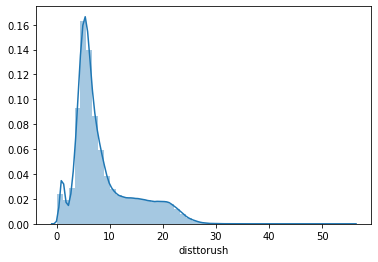

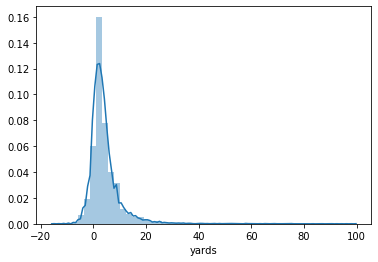

In [17]:
# distribution of players' distance to rusher
sns.distplot(data['disttorush'][data['rusher'] == 0])
plt.show()

# distribution of yards gained/play
sns.distplot(data['yards'])
plt.show()

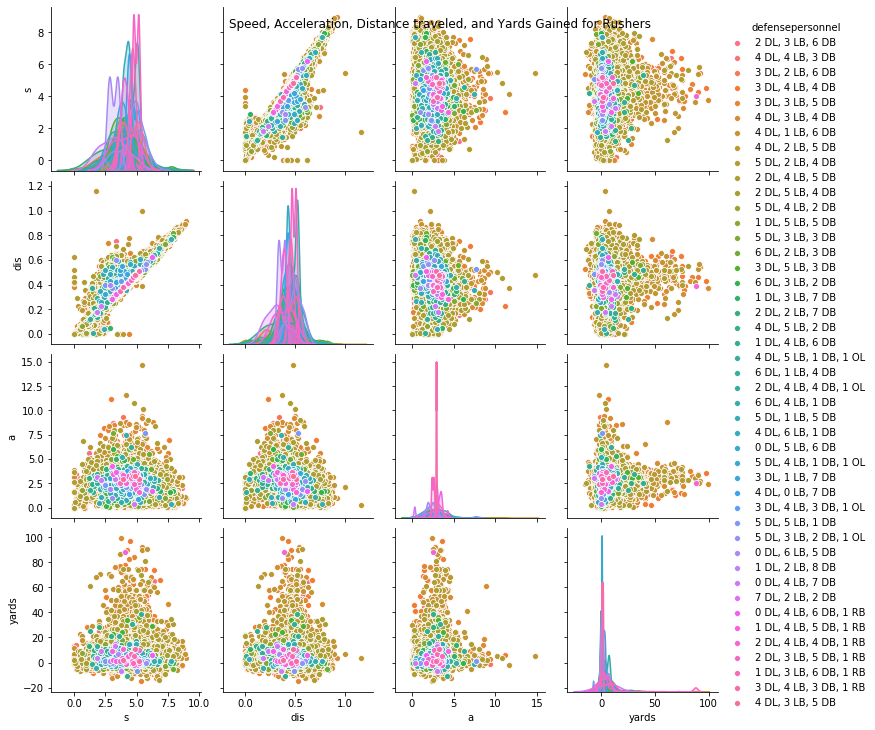

In [29]:
# Pair plot of speed, accleration, distance traveled, and yards gained
sns.pairplot(data.query("nflidrusher == nflid")[['s','dis','a','yards','defensepersonnel']],
            hue = 'defensepersonnel')
plt.suptitle('Speed, Acceleration, Distance traveled, and Yards Gained for Rushers')
plt.show()


#### Offensive and Defensive Personnel 

In [30]:
# count defensive position
# differentiate defensive ol and offensive ol - JM
data["ol_d"] = data["defensepersonnel"].str.extract(pat="([1-9] OL)")
data["ol_d"] = data["ol_d"].str.extract(pat="([1-9])")
data["dl"] = data["defensepersonnel"].str.extract(pat="([1-9] DL)")
data["dl"] = data["dl"].str.extract(pat="([1-9])")
data["lb"] = data["defensepersonnel"].str.extract(pat="([1-9] LB)")
data["lb"] = data["lb"].str.extract(pat="([1-9])")
data["db"] = data["defensepersonnel"].str.extract(pat="([1-9] DB)")
data["db"] = data["db"].str.extract(pat="([1-9])")
# differentiate defensive rb and offensive rb - JM
data["rb_d"] = data["defensepersonnel"].str.extract(pat="([1-9] RB)")
data["rb_d"] = data["rb_d"].str.extract(pat="([1-9])")

In [31]:
# count offensive position
# QB, OL, RB, TE, WR, DL, LB, DB
data['qb'] = data['offensepersonnel'].str.extract(pat='([1-9] QB)')
data['qb'] = data['qb'].str.extract(pat='([1-9])')
data['ol'] = data['offensepersonnel'].str.extract(pat='([1-9] OL)')
data['ol'] = data['ol'].str.extract(pat='([1-9])')
data['rb'] = data['offensepersonnel'].str.extract(pat='(\d RB)')
data['rb'] = data['rb'].str.extract(pat='(\d)')
data['te'] = data['offensepersonnel'].str.extract(pat='(\d TE)')
data['te'] = data['te'].str.extract(pat='(\d)')
data['wr'] = data['offensepersonnel'].str.extract(pat='(\d WR)')
data['wr'] = data['wr'].str.extract(pat='(\d)')
# differentiate offensive dl - JM
data['dl_o'] = data['offensepersonnel'].str.extract(pat='(\d DL)')
data['dl_o'] = data['dl_o'].str.extract(pat='(\d)')
data['lb_o'] = data['offensepersonnel'].str.extract(pat='(\d LB)')
data['lb_o'] = data['lb_o'].str.extract(pat='(\d)')
data['db_o'] = data['offensepersonnel'].str.extract(pat='(\d DB)')
data['db_o'] = data['db_o'].str.extract(pat='(\d)')

In [32]:
# replace nas with 0
data['ol'].fillna(0, inplace = True)
data['dl'].fillna(0, inplace = True)
data['db'].fillna(0, inplace = True)
data['lb'].fillna(0, inplace = True)
data['rb'].fillna(0, inplace = True)
data['ol_d'].fillna(0, inplace = True)
data['rb_d'].fillna(0, inplace = True)
data['te'].fillna(0, inplace = True)
data['wr'].fillna(0, inplace = True)
data['dl_o'].fillna(0, inplace = True)
data['lb_o'].fillna(0, inplace = True)
data['db_o'].fillna(0, inplace = True)
# replace qb nas with 1 - WILDCAT has a qb, but the ball is snapped to someone else - JM
data['qb'].fillna(1, inplace = True)

In [33]:
# set ol == 0 to be 11 - sum(offensive personnel)
off = ['rb', 'qb', 'te', 'wr', 'dl_o', 'lb_o', 'db_o'] 
data[off] = data[off].astype(str).astype(int)
data['ol'][data['ol'] == 0] = 11 - data[off].sum(axis = 1)

In [34]:
# convert rest of personnel to int
defp = ['dl', 'lb', 'rb_d', 'ol_d', 'db']
data[defp] = data[defp].astype(str).astype(int)
# fill lb na with 11 - sum(everyone else on defense)
data['lb'][data['lb'] == 0] = 11 - data[defp].sum(axis = 1)

In [ ]:
data[13109:131114]

In [ ]:
# distritbution of ol/play
sns.countplot(data['ol'])

In [ ]:
# distribution of wr/play
sns.countplot(data['wr'])
plt.show()

sns.distplot(data['wr'])
plt.show

In [ ]:
# distribution of db/play
sns.countplot(data['db'])

### Reshape dataframe

#### Function to Plot Football Field

In [208]:
import matplotlib.patches as patches
# los = line of scrimmage
'''
function defines default parameters that can be turned on/off
returns rectangle that resembles the field
bottom left corner is (0,0)

parameters: 
    turn on/off 
        - line numbers 
        - endzones
        - highlighted los
        - fifty yard line as default los
    highlight_los_number = yard line of los
'''
def plot_field(linenumbers = True, # show numbers on the field
              endzones = True, # can turn endzones on/off
              highlight_los = False, # show line of scrimmage
              highlight_los_number = 50, # default line of scrimmage = 50
              highlighted_name = 'Line of Scrimmage',
              fifty_is_los = False, # use default line of scrimmage
              figsize = (12, 5.33)): # 1/10 scale of the 120 x 53.3
    # define the rectangle that is the field
    field = patches.Rectangle((0,0), 120, 53.3, linewidth = 0.1,
                             edgecolor = 'red',
                             facecolor = 'seagreen',
                             zorder = 0) # zorder = 0 - plot this first
    fig, ax = plt.subplots(1, figsize = figsize)
    # add the patch to the axes
    ax.add_patch(field)
    # define the field markers
    # first list is the x-coord, second is the y-coord 
    # the map together to plot vertical lines
    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120], 
            [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
            color = 'white')    
    # check for line of scrimmage
    if fifty_is_los:
        plt.plot([60,60], [0, 53.3], color = 'gold')
        plt.text(62, 50, '<- Line of Scrimmage', color = 'gold')
    # color the endzones so they stand out, if set to True
    if endzones:
        endzone1 = patches.Rectangle((0,0), 10, 53.3, # left endzone
                                    linewidth = 0.1,
                                    edgecolor = 'red',
                                    facecolor = 'yellow', # color of endzone
                                    alpha = 0.8, # transparency
                                    zorder = 0)
        endzone2 = patches.Rectangle((110,0), 120, 53.3, # right endzone
                                    linewidth = 0.1,
                                    edgecolor = 'red',
                                    facecolor = 'yellow',
                                    alpha = 0.8,
                                    zorder = 0)
        # add the patches to the endzones
        ax.add_patch(endzone1)
        ax.add_patch(endzone2)
        # set plot limits for the field
        plt.xlim(0, 120)
        plt.ylim(-5, 58.3) # a little extra padding on top and bottom
        plt.axis('off')
        # line numbers = True
        if linenumbers:
            for x in range(20, 110, 10): # start at the goalline and end on the goalline
                number = x
                # start with 20,30... once we get to midfield count backward
                if x > 50:
                    number = 120 - x
                # bottom numbers
                plt.text(x, 5, str(number - 10),
                        horizontalalignment = 'center',
                        fontsize = 20,
                        color = 'white')
                # top numbers
                plt.text(x - 0.95, 53.3 - 5, str(number - 10), # numbers are kind of off
                        horizontalalignment = 'center',
                        fontsize = 20,
                        color = 'white',
                        rotation = 180) # turn upside down to mimic a real field
    # set hash marks for middle of field and sidelines
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(0, 120)
    # print the hash marks on each yard line
    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color = 'white') #bottom sideline
        ax.plot([x, x], [53.0, 52.5], color = 'white') #top sideline
        ax.plot([x, x], [22.91, 23.57], color = 'white') # right hash - middle of field
        ax.plot([x, x], [29.73, 30.59], color = 'white') # left hash - middle of field
    # if highlight_los = True 
    if highlight_los:
        h1 = highlight_los_number + 10# account for the endzone
        plt.vlines(x = h1, 
                   ymin = 0, 
                   ymax = 53.3,
                  color = 'gold',
                  linestyle = 'dashed')
        #plt.plot([h1, h1], [0, 53.3], # define from bottom to top
         #        color = 'gold',
          #      ls = '-') 
        #plt.text(h1 + 2, 50, '<- {}'.format(highlighted_name), 
         #        color = 'gold')
    
    return fig, ax

In [210]:
# function to plot a play - arrows are direction
'''
    Requires a play ID
    can turn on/off orientation and direction arrows
    can turn on/off end of play yard line
    default is on
    '''
def plot_play(playid, 
             show_end = True, # show the finish yard line of the play
             show_orientation = True, # turn on/off orientation arrow (default = on)
             show_direction = True): # turn on/off direction arrow (default = on)
    import math
    play_info = data.loc[data['playid'] == playid]
    # scatter plot of players initial position
    # plot away team
    data.loc[(data['playid'] == playid)&(data['team'] == 'away')].plot(
        x = 'x_standard', 
        y = 'y_standard', 
        kind = 'scatter', 
        ax = ax, 
        color = 'blue',
        s = 30, 
        legend = 'Away')
    # plot home team
    data.loc[(data['playid'] == playid)&(data['team'] == 'home')].plot(
        x = 'x_standard',
        y = 'y_standard',
        kind = 'scatter',
        ax = ax,
        color = 'tab:orange',
        s = 30,
        legend = 'Home')
  # define orientation arrow
    if show_orientation:
        for index, row in play_info.iterrows():
            # length of arrow = 1.25 - just to show it a bit
            dx = 1.25 * math.cos(math.radians(row['orientation']))
            dy = 1.25 * math.sin(math.radians(row['orientation']))
            # plot the arrow
            plt.arrow(x = row['x_standard'],
                     y = row['y_standard'],
                     dx = dx,
                     dy = dy,
                     color = 'blue' if row['team'] == 'away' else 'tab:orange')
    # define direction arrow
    if show_direction:
        for index, row in play_info.iterrows():
            # calculate distance traveled after 2 second
            d = row['s'] + row['a'] 
            dx = d * math.cos(math.radians(row['dir']))
            dy = d * math.sin(math.radians(row['dir']))
            # plot the arrow
            plt.arrow(x = row['x_standard'],
                     y = row['y_standard'],
                     dx = dx,
                     dy = dy,
                     head_starts_at_zero = True,
                     length_includes_head = True,
                     head_width = 0.5, 
                     color = 'blue' if row['team'] == 'away' else 'tab:orange')
    # plot the finish yard line
    if show_end:
        for index, row in play_info.iterrows():
            if row['x_standard'] > 60:
                end_of_play = 110 - row['yardline'] + row['yards']
            else:
                end_of_play = row['yardline'] + row['yards'] + 10
        plt.vlines(x = end_of_play,
                  ymin = 0,
                  ymax = 53.3,                      
                   color = 'red')
    plt.title('Home: {}  Away: {}   Possession Team: {}'.format(row['hometeamabbr'], row['visitorteamabbr'], row['possessionteam']))    

In [211]:
# define a line of scrimmage function
def line_of_scrimmage(playid, df):
    play_info = df.loc[df['playid'] == playid]
    if play_info['x_standard'].tolist()[0] > 60:
        los = 110 - play_info['yardline'].tolist()[0]
    else:
        los = play_info['yardline'].tolist()[0]
    return los

In [212]:
line_of_scrimmage(playid, data)

31

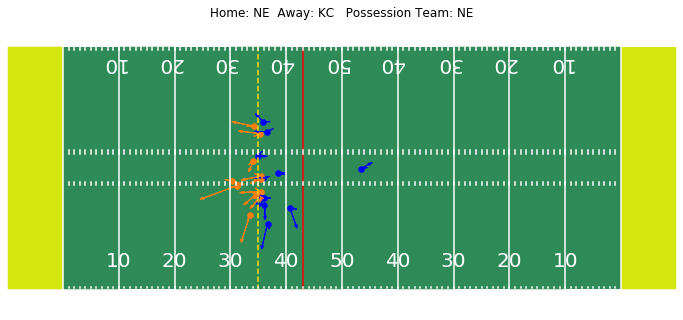

In [213]:
# plot a play
playid = 20170907000118
los = line_of_scrimmage(playid, data)
#play_info = data.loc[data['playid'] == playid]
#if play_info['x_standard'].tolist()[0] > 60:
#   los = 110 - play_info['yardline'].tolist()[0]
#else:
#    los = play_info['yardline'].tolist()[0]
#print(los)
#data.loc[data['playid'] == playid]
fig, ax = plot_field(highlight_los = True,
                    highlight_los_number = los)
plot_play(playid)
plt.show()

35
31
8


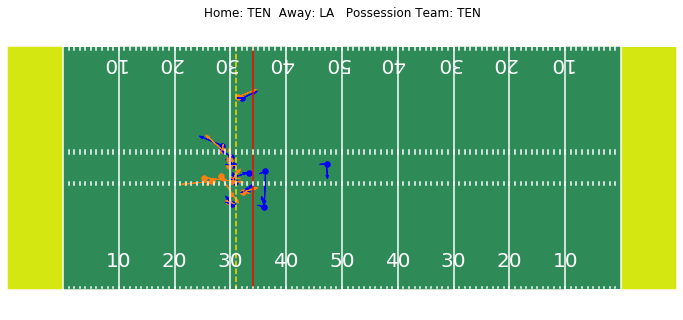

In [154]:
# plot a play
playid = list(set(data['playid']))[19098]
los = line_of_scrimmage(playid, data)
print(play_info['yardline'].tolist()[0])
print(los)
print(play_info['yards'].tolist()[0])
#data.loc[data['playid'] == playid]
fig, ax = plot_field(highlight_los = True,
                    highlight_los_number = los)
plot_play(playid)
plt.show()
del plt

In [155]:
# this function sets what team the player is on
def teamIdentitySet(x):
    if x["team"] == "home":
        return x["hometeamabbr"]
    else:
        return x["visitorteamabbr"]
# applying function entire data df
data["teamidentity"] = data.apply(teamIdentitySet, axis=1)

In [156]:
#  create row called yards from own goal
def createYardsFromOwnGoal(x):
    # if the ball is on the possession teams side, just return yardline
    if x["fieldposition"] == x["possessionteam"]:
        return x["yardline"]
    else:
    # if the ball is not on the possesion team side, convert
        return (50 + (50-x["yardline"]))
data["yardfromowngoal"] = data.apply(createYardsFromOwnGoal,axis = 1)

In [9]:
def standardizeXCoordinates(x):
    if x["playdirection"] == "left":
        return 120 - x["x"] 
    else:
        return x["x"] 
def standardizeYCoordinates(x):
    if x["playdirection"] == "left":
        return 160/3 - x["y"]
    else:
        return x["y"]

In [10]:
data["x_standard"] = data.apply(standardizeXCoordinates,axis=1)
data["y_standard"] = data.apply(standardizeYCoordinates, axis=1)

In [158]:
pd.set_option('max_columns', None)
data.head()

,gameid,playid,team,x,y,s,a,dis,orientation,dir,nflid,displayname,jerseynumber,season,yardline,quarter,gameclock,possessionteam,down,distance,fieldposition,homescorebeforeplay,visitorscorebeforeplay,nflidrusher,offenseformation,offensepersonnel,defendersinthebox,defensepersonnel,playdirection,timehandoff,timesnap,yards,playerheight,playerweight,playerbirthdate,playercollegename,position,hometeamabbr,visitorteamabbr,week,stadium,location,stadiumtype,turf,gameweather,temperature,humidity,windspeed,winddirection,age,x_standard,y_standard,rusher,rushx,rushy,disttorush,ol_d,dl,lb,db,rb_d,qb,ol,rb,te,wr,dl_o,lb_o,db_o,teamidentity,yardfromowngoal
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,278.01,272.82,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,72,212,1988-12-29,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,29,46.09,18.493333,0,78.75,30.53,6.480872,0,2,3,6,0,1,5,1,1,3,0,0,0,KC,35
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,332.39,251.30,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,288,1989-03-25,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,28,45.33,20.693333,0,78.75,30.53,4.593310,0,2,3,6,0,1,5,1,1,3,0,0,0,KC,35
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,356.99,247.27,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,270,1989-01-21,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,28,46.00,20.133333,0,78.75,30.53,5.448982,0,2,3,6,0,1,5,1,1,3,0,0,0,KC,35
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,0.23,344.36,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,245,1982-11-22,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,35,48.54,25.633333,0,78.75,30.53,7.820038,0,2,3,6,0,1,5,1,1,3,0,0,0,KC,35
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,347.37,285.69,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,72,206,1987-08-17,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,30,50.68,17.913333,0,78.75,30.53,10.622476,0,2,3,6,0,1,5,1,1,3,0,0,0,KC,35


#### future location

In [215]:
# get future x coordinate
def future_x(df):
    '''
    input: df - designed to be used with apply()
    calculates: new x coordinate with speed, acceleration, and direction
    Returns: new x-coordinate
    '''
    import math
    # distance traveled = speed(time) + acceleration(time)^2
    distance = df['s']*t + df['a']*t**2 
    # delta x = cos(direction)  convert to radians
    dx = distance * math.cos(math.radians(df['dir'])) 
    # future = initial position + change
    new_x = df['x_standard'] + dx
    # can't have coordinates outside the boundaries
    if new_x < 0:
        new_x = 0
    elif new_x > 120:
        new_x = 120
    return new_x
    
# get future y coordinate
def future_y(df):
    '''
    input: df - designed to be used with apply()
    calculates: new y coordinate with speed, acceleration, and direction
    Returns: new y-coordinate
    '''
    import math
     # distance traveled = speed(time) + acceleration(time)^2
    distance = df['s']*t + df['a']*t**2 
    # delta y = sin(direction)  convert to radians
    dy = distance * math.sin(math.radians(df['dir'])) 
    # future = initial position + change 
    new_y = df['y_standard'] + dy
    # can't have coordinates outside the boundaries
    if new_y < 0:
        new_y = 0
    elif new_y > 53.3:
        new_y = 53.3
    return new_y

In [216]:
times = np.arange(0.5, 6.5, 0.5)
for t in times:
    sub['{}_sec_x'.format(t)] = sub.apply(future_x, axis = 1)
    sub['{}_sec_y'.format(t)] = sub.apply(future_y, axis = 1)
sub.head()

,gameid,playid,team,x,y,s,a,dis,orientation,dir,nflid,displayname,jerseynumber,season,yardline,quarter,gameclock,possessionteam,down,distance,fieldposition,homescorebeforeplay,visitorscorebeforeplay,nflidrusher,offenseformation,offensepersonnel,defendersinthebox,defensepersonnel,playdirection,timehandoff,timesnap,yards,playerheight,playerweight,playerbirthdate,playercollegename,position,hometeamabbr,visitorteamabbr,week,stadium,location,stadiumtype,turf,gameweather,temperature,humidity,windspeed,winddirection,age,x_standard,y_standard,rusher,rushx,rushy,disttorush,ol_d,dl,lb,db,rb_d,qb,ol,rb,te,wr,dl_o,lb_o,db_o,teamidentity,yardfromowngoal,0.5_sec_x,0.5_sec_y,1.0_sec_x,1.0_sec_y,1.5_sec_x,1.5_sec_y,2.0_sec_x,2.0_sec_y,2.5_sec_x,2.5_sec_y,3.0_sec_x,3.0_sec_y,3.5_sec_x,3.5_sec_y,4.0_sec_x,4.0_sec_y,4.5_sec_x,4.5_sec_y,5.0_sec_x,5.0_sec_y,5.5_sec_x,5.5_sec_y,6.0_sec_x,6.0_sec_y
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,278.01,272.82,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,72,212,1988-12-29,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,29,46.09,18.493333,0,78.75,30.53,6.480872,0,2,3,6,0,1,5,1,1,3,0,0,0,KC,35,46.145471,17.367199,46.228740,15.676748,46.339805,13.421982,46.478667,10.602900,46.645327,7.219502,46.839784,3.271789,47.062038,0.000000,47.312089,0.000000,47.589937,0.000000,47.895582,0.000000,48.229024,0.000000,48.590263,0.000000
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,332.39,251.30,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,288,1989-03-25,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,28,45.33,20.693333,0,78.75,30.53,4.593310,0,2,3,6,0,1,5,1,1,3,0,0,0,KC,35,45.154464,20.174736,44.762515,19.016771,44.154152,17.219440,43.329375,14.782741,42.288184,11.706676,41.030580,7.991244,39.556562,3.636444,37.866130,0.000000,35.959284,0.000000,33.836024,0.000000,31.496351,0.000000,28.940264,0.000000
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,356.99,247.27,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,270,1989-01-21,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,28,46.00,20.133333,0,78.75,30.53,5.448982,0,2,3,6,0,1,5,1,1,3,0,0,0,KC,35,45.707310,19.434664,45.300636,18.463905,44.779977,17.221058,44.145333,15.706121,43.396704,13.919095,42.534090,11.859980,41.557492,9.528776,40.466909,6.925483,39.262341,4.050101,37.943789,0.902630,36.511251,0.000000,34.964729,0.000000
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,0.23,344.36,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,245,1982-11-22,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,35,48.54,25.633333,0,78.75,30.53,7.820038,0,2,3,6,0,1,5,1,1,3,0,0,0,KC,35,48.872226,25.540324,49.464456,25.374525,50.316688,25.135936,51.428924,24.824557,52.801163,24.440388,54.433404,23.983429,56.325650,23.453681,58.477898,22.851142,60.890149,22.175814,63.562404,21.427695,66.494661,20.606787,69.686922,19.713089
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,347.37,285.69,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,72,206,1987-08-17,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,30,50.68,17.913333,0,78.75,30.53,10.62

In [217]:
### This takes a while to run - lots of calculations

# set a time interval (begin, end, step)
times = np.arange(0.5, 6.5, 0.5)
for t in times:
    data['{}_sec_x'.format(t)] = data.apply(future_x, axis = 1)
    data['{}_sec_y'.format(t)] = data.apply(future_y, axis = 1)
data.head()

,gameid,playid,team,x,y,s,a,dis,orientation,dir,nflid,displayname,jerseynumber,season,yardline,quarter,gameclock,possessionteam,down,distance,fieldposition,homescorebeforeplay,visitorscorebeforeplay,nflidrusher,offenseformation,offensepersonnel,defendersinthebox,defensepersonnel,playdirection,timehandoff,timesnap,yards,playerheight,playerweight,playerbirthdate,playercollegename,position,hometeamabbr,visitorteamabbr,week,stadium,location,stadiumtype,turf,gameweather,temperature,humidity,windspeed,winddirection,age,x_standard,y_standard,rusher,rushx,rushy,disttorush,ol_d,dl,lb,db,rb_d,qb,ol,rb,te,wr,dl_o,lb_o,db_o,teamidentity,yardfromowngoal,0.5_sec_x,0.5_sec_y,1.0_sec_x,1.0_sec_y,1.5_sec_x,1.5_sec_y,2.0_sec_x,2.0_sec_y,2.5_sec_x,2.5_sec_y,3.0_sec_x,3.0_sec_y,3.5_sec_x,3.5_sec_y,4.0_sec_x,4.0_sec_y,4.5_sec_x,4.5_sec_y,5.0_sec_x,5.0_sec_y,5.5_sec_x,5.5_sec_y,6.0_sec_x,6.0_sec_y
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,278.01,272.82,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,72,212,1988-12-29,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,29,46.09,18.493333,0,78.75,30.53,6.480872,0,2,3,6,0,1,5,1,1,3,0,0,0,KC,35,46.145471,17.367199,46.228740,15.676748,46.339805,13.421982,46.478667,10.602900,46.645327,7.219502,46.839784,3.271789,47.062038,0.000000,47.312089,0.000000,47.589937,0.000000,47.895582,0.000000,48.229024,0.000000,48.590263,0.000000
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,332.39,251.30,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,288,1989-03-25,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,28,45.33,20.693333,0,78.75,30.53,4.593310,0,2,3,6,0,1,5,1,1,3,0,0,0,KC,35,45.154464,20.174736,44.762515,19.016771,44.154152,17.219440,43.329375,14.782741,42.288184,11.706676,41.030580,7.991244,39.556562,3.636444,37.866130,0.000000,35.959284,0.000000,33.836024,0.000000,31.496351,0.000000,28.940264,0.000000
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,356.99,247.27,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,270,1989-01-21,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,28,46.00,20.133333,0,78.75,30.53,5.448982,0,2,3,6,0,1,5,1,1,3,0,0,0,KC,35,45.707310,19.434664,45.300636,18.463905,44.779977,17.221058,44.145333,15.706121,43.396704,13.919095,42.534090,11.859980,41.557492,9.528776,40.466909,6.925483,39.262341,4.050101,37.943789,0.902630,36.511251,0.000000,34.964729,0.000000
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,0.23,344.36,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,245,1982-11-22,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,35,48.54,25.633333,0,78.75,30.53,7.820038,0,2,3,6,0,1,5,1,1,3,0,0,0,KC,35,48.872226,25.540324,49.464456,25.374525,50.316688,25.135936,51.428924,24.824557,52.801163,24.440388,54.433404,23.983429,56.325650,23.453681,58.477898,22.851142,60.890149,22.175814,63.562404,21.427695,66.494661,20.606787,69.686922,19.713089
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,347.37,285.69,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,72,206,1987-08-17,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,30,50.68,17.913333,0,78.75,30.53,10.62

In [222]:
# effective downfield acceleration
def eff_df_acc(df):
    '''
    input: dataframe
    calculates: x component of acceleration
    returns: x component
    positive -> left to right
    negative -> right to left
    '''
    downfield_acc = df['a'] * math.cos(math.radians(df['dir']))
    return downfield_acc

# effective crossfield accleration
def eff_cf_acc(df):
    '''
    input: dataframe
    calculates: y component of acceleration
    returns: y component
    positive -> up toward "far sideline"
    negative -> down toward "near sideline"
    '''
    crossfield_acc = df['a'] * math.sin(math.radians(df['dir']))
    return crossfield_acc

In [225]:
data['eff_downfield_acc'] = data.apply(eff_df_acc, axis = 1)
data['eff_crossfield_acc'] = data.apply(eff_cf_acc, axis = 1)
data.head()

,gameid,playid,team,x,y,s,a,dis,orientation,dir,nflid,displayname,jerseynumber,season,yardline,quarter,gameclock,possessionteam,down,distance,fieldposition,homescorebeforeplay,visitorscorebeforeplay,nflidrusher,offenseformation,offensepersonnel,defendersinthebox,defensepersonnel,playdirection,timehandoff,timesnap,yards,playerheight,playerweight,playerbirthdate,playercollegename,position,hometeamabbr,visitorteamabbr,week,stadium,location,stadiumtype,turf,gameweather,temperature,humidity,windspeed,winddirection,age,x_standard,y_standard,rusher,rushx,rushy,disttorush,ol_d,dl,lb,db,rb_d,qb,ol,rb,te,wr,dl_o,lb_o,db_o,teamidentity,yardfromowngoal,0.5_sec_x,0.5_sec_y,1.0_sec_x,1.0_sec_y,1.5_sec_x,1.5_sec_y,2.0_sec_x,2.0_sec_y,2.5_sec_x,2.5_sec_y,3.0_sec_x,3.0_sec_y,3.5_sec_x,3.5_sec_y,4.0_sec_x,4.0_sec_y,4.5_sec_x,4.5_sec_y,5.0_sec_x,5.0_sec_y,5.5_sec_x,5.5_sec_y,6.0_sec_x,6.0_sec_y,eff_downfield_acc,eff_crossfield_acc
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,278.01,272.82,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,72,212,1988-12-29,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,29,46.09,18.493333,0,78.75,30.53,6.480872,0,2,3,6,0,1,5,1,1,3,0,0,0,KC,35,46.145471,17.367199,46.228740,15.676748,46.339805,13.421982,46.478667,10.602900,46.645327,7.219502,46.839784,3.271789,47.062038,0.000000,47.312089,0.000000,47.589937,0.000000,47.895582,0.000000,48.229024,0.000000,48.590263,0.000000,0.055594,-1.128632
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,332.39,251.30,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,288,1989-03-25,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,28,45.33,20.693333,0,78.75,30.53,4.593310,0,2,3,6,0,1,5,1,1,3,0,0,0,KC,35,45.154464,20.174736,44.762515,19.016771,44.154152,17.219440,43.329375,14.782741,42.288184,11.706676,41.030580,7.991244,39.556562,3.636444,37.866130,0.000000,35.959284,0.000000,33.836024,0.000000,31.496351,0.000000,28.940264,0.000000,-0.432828,-1.278734
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,356.99,247.27,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,270,1989-01-21,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,28,46.00,20.133333,0,78.75,30.53,5.448982,0,2,3,6,0,1,5,1,1,3,0,0,0,KC,35,45.707310,19.434664,45.300636,18.463905,44.779977,17.221058,44.145333,15.706121,43.396704,13.919095,42.534090,11.859980,41.557492,9.528776,40.466909,6.925483,39.262341,4.050101,37.943789,0.902630,36.511251,0.000000,34.964729,0.000000,-0.227970,-0.544178
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,0.23,344.36,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,245,1982-11-22,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,35,48.54,25.633333,0,78.75,30.53,7.820038,0,2,3,6,0,1,5,1,1,3,0,0,0,KC,35,48.872226,25.540324,49.464456,25.374525,50.316688,25.135936,51.428924,24.824557,52.801163,24.440388,54.433404,23.983429,56.325650,23.453681,58.477898,22.851142,60.890149,22.175814,63.562404,21.427695,66.494661,20.606787,69.686922,19.713089,0.520006,-0.145580
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,347.37,285.69,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,72,206,1987-08-17,Newberry,FS,NE,KC,1,Gillet

#### Get Possession, Home, Visitor abbreviations consistent

In [354]:
# find teams with mismatched abbreviations
for home_abbr, pos_abbr in zip(sorted(data['hometeamabbr'].unique()),
                                     sorted(data['possessionteam'].unique())):
    if home_abbr != pos_abbr:
        print(home_abbr + ' ' + pos_abbr )


In [313]:
# define a mapping to fix these
def map_abbr(df):
    '''
    input: dataframe
    function: fixes incorrect abbreviations in possession team
    returns: correct abbreviations
    '''
    home_abbr = df['hometeamabbr']
    pos_abbr = df['possessionteam']
    if home_abbr != pos_abbr:
        pos_abbr = home_abbr
    return pos_abbr

data['possessionteam'] = data.apply(map_abbr, axis = 1)
data['possessionteam'].unique()

array(['NE', 'BUF', 'CHI', 'CIN', 'CLE', 'DET', 'HOU', 'TEN', 'WAS', 'LA',
       'GB', 'SF', 'DAL', 'MIN', 'DEN', 'BAL', 'CAR', 'IND', 'JAX', 'KC',
       'NO', 'PIT', 'TB', 'LAC', 'OAK', 'SEA', 'ATL', 'NYG', 'NYJ', 'PHI',
       'ARI', 'MIA'], dtype=object)

#### Mean Yards Per Attempt

In [355]:
# get each season
df17 = data.loc[data['season'] == 2017]
df18 = data.loc[data['season'] == 2018]
df19 = data.loc[data['season'] == 2019]

# get avg yards per attempt by team
avg_yards_17 = df17.groupby('possessionteam')['yards'].mean()
avg_yards_18 = df18.groupby('possessionteam')['yards'].mean()
avg_yards_19 = df19.groupby('possessionteam')['yards'].mean()

# get a list of teams
team_list = list(data['teamidentity'].unique())

del df17, df18, df19

#avg_yards_19

possessionteam
ARI    4.525114
ATL    3.380282
BAL    5.333333
BUF    4.699634
CAR    5.129464
CHI    3.275424
CIN    4.439689
CLE    4.393822
DAL    4.727642
DEN    4.396552
DET    4.072340
GB     4.856164
HOU    3.918103
IND    4.339552
JAX    4.204188
KC     4.995434
LA     3.766551
LAC    4.452756
MIA    3.751908
MIN    4.396761
NE     3.625000
NO     4.684426
NYG    4.783186
NYJ    3.220930
OAK    4.241259
PHI    3.762452
PIT    3.836000
SEA    3.830986
SF     5.034130
TB     3.623116
TEN    4.642586
WAS    4.274021
Name: yards, dtype: float64

In [359]:
# average yards per rush attempt for each team for each season
def mean_ypa(df):
    '''
    input: dataframe
    operation: map the mean yards per attempt of each team and season
    returns: mean yards per attempt for that team in that season
    '''
    for team in team_list:
        # 2017 season
        if (df['teamidentity'] == team) & (df['season'] == 2017):
            ypa = avg_yards_17[team]
        # 2018 season
        elif (df['teamidentity'] == team) & (df['season'] == 2018):
            ypa = avg_yards_18[team]
        # 2019 season
        elif (df['teamidentity'] == team) & (df['season'] == 2019):
            ypa = avg_yards_19[team]
        else:
            continue
        
        return ypa

In [364]:
data['mean_yards_per_rush'] = data.apply(mean_ypa, axis = 1)
#data[['teamidentity', 'possessionteam', 'mean_yards_per_rush']].sample(n = 25)

,teamidentity,possessionteam,mean_yards_per_rush
323469,TEN,BUF,4.382920
170175,BUF,KC,4.539952
622892,TB,TEN,3.623116
318055,SF,LAC,4.454545
469719,CIN,CIN,4.808219
279440,BUF,BUF,3.593496
439254,CHI,NYG,3.439169
436453,HOU,HOU,3.824242
678331,DAL,NE,4.727642
157573,KC,NYG,4.301493


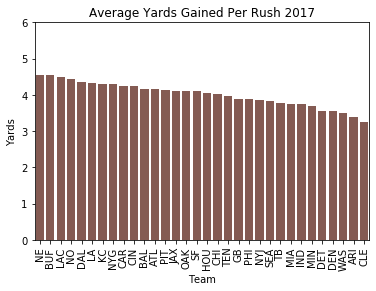

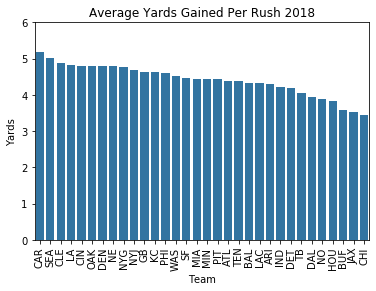

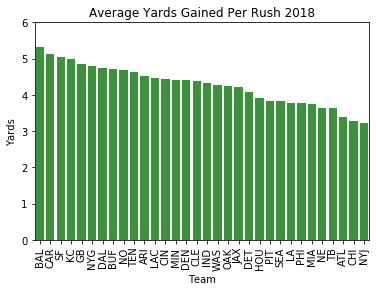

In [387]:


# distribution of mean yards per rush 2017
df = data.loc[data['season'] == 2017].sort_values('mean_yards_per_rush', ascending = False)
sns.barplot(x = 'teamidentity', 
            y = 'mean_yards_per_rush', 
            data = df,
           color = 'tab:brown')
plt.xticks(rotation = 90)
plt.xlabel('Team')
plt.ylabel('Yards')
plt.title('Average Yards Gained Per Rush 2017')
plt.ylim(0, 6)
plt.show()
del df
# distribution of mean yards per rush 2018
df = data.loc[data['season'] == 2018].sort_values('mean_yards_per_rush', ascending = False)
sns.barplot(x = 'teamidentity', 
            y = 'mean_yards_per_rush', 
            data = df,
           color = 'tab:blue')
plt.xticks(rotation = 90)
plt.xlabel('Team')
plt.ylabel('Yards')
plt.title('Average Yards Gained Per Rush 2018')
plt.ylim(0, 6)
plt.show()
del df
# distribution of mean yards per rush 2019
df = data.loc[data['season'] == 2019].sort_values('mean_yards_per_rush', ascending = False)
sns.barplot(x = 'teamidentity', 
            y = 'mean_yards_per_rush', 
            data = df,
           color = 'tab:green')
plt.xticks(rotation = 90)
plt.xlabel('Team')
plt.ylabel('Yards')
plt.title('Average Yards Gained Per Rush 2019')
plt.ylim(0, 6)
plt.show()
del df

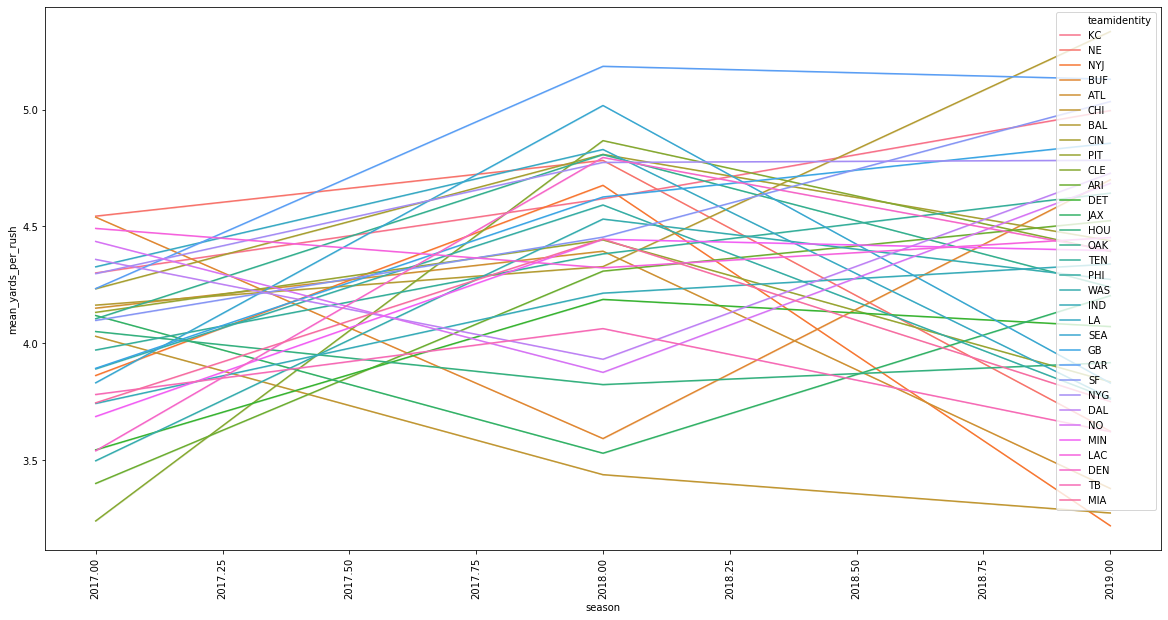

In [391]:
plt.figure(figsize = (20, 10))
sns.lineplot(x = 'season',
           y = 'mean_yards_per_rush',
           hue = 'teamidentity',
           data = data)
plt.xticks(rotation = 90)
plt.show()

# x distance traveled (downfield)
# offense -> left to right (positive)
# defense -> right to left (negative)

In [ ]:
# minimum tackler distance away 
# defense is if possession team != teamidentity

In [ ]:
# defenders blocked
# defensive player is within 1.5 yards of offensive player

In [ ]:
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import cross_val_score

In [ ]:
#x.select_dtypes([np.number]).head()
cols_to_drop = ['gameid', 'playid', 'x', 'y', 'orientation', 'dir', 'nflid', 
               'jerseynumber', 'season', 'nflidrusher', 'week', 'yards',
               'temperature', 'humidity', 'windspeed']

In [ ]:
print(int(n_plays * (len(data)/22)))
print(len(data)/22)
print(int(len(data)/22*0.8))

In [ ]:
24805 * 22 - 1 

In [ ]:
# define prediction and output
y = sub['yards']
x = sub.drop(cols_to_drop, axis = 1)

# one-hot encoding
x = pd.get_dummies(x)

# get only numeric variables
x = x.select_dtypes([np.number])
x = x.fillna(0)

n_plays = 80 # number of plays in the train set

cutoff = int(len(sub)/22*0.8) * 22 
print(cutoff)
Xtrain, Xtest, ytrain, ytest = x[:cutoff], x[cutoff:], y[:cutoff], y[cutoff:]

print('train x: {}'.format(Xtrain.shape))
print('test x: {}'.format(Xtest.shape))
print('train y: {}'.format(ytrain.shape))
print('test y: {}'.format(ytest.shape))

In [ ]:
x.isna().sum()

In [ ]:
clf = rfc(n_estimators = 100)
clf.fit(Xtrain, ytrain)
y_pred = clf.predict(Xtest)
errors = abs(y_pred - ytest)
acc = clf.score(Xtest, ytest)
print('Accuracy: %.2f' % acc)
print('Mean Absolute Error: %.2f' %errors.mean())

In [ ]:
# reindex ytest
ytest.index = range(len(ytest))
ytest[0]

In [ ]:
# are predictions within 1 yard?
wr = []
for i in range(len(y_pred)):
        if abs(y_pred[i] - ytest[i]) <= 1:
            wr.append(1)
        else:
            wr.append(0)
sum(wr)/len(wr)

In [ ]:
# cross validation
scores = cross_val_score(clf, x, y, cv = 3)
print(scores.mean())

In [ ]:
p = data[:1]['x_standard'] + data[:1]['s'] + data[:1]['a'] ** 2
p - data[:1]['x_standard']

In [ ]:
# Transform stadium type
def clean_stad_type(txt):
    if pd.isna(txt):
        return np.nan
    txt = txt.lower()
    #txt = ''.join([c for c in txt if c not in punctuation])
    txt = re.sub(' +', ' ', txt)
    txt = txt.strip()
    txt = txt.replace('outside', 'outdoor')
    txt = txt.replace('outdor', 'outdoor')
    txt = txt.replace('outddors', 'outdoor')
    txt = txt.replace('outdoors', 'outdoor')
    txt = txt.replace('oudoor', 'outdoor')
    txt = txt.replace('indoors', 'indoor')
    txt = txt.replace('ourdoor', 'outdoor')
    txt = txt.replace('retractable', 'rtr.')
    return txt
data['stadiumtype'] = data['stadiumtype'].apply(clean_stad_type)

In [ ]:
# focus only on outdoor, indoor, open, and closed
def num_stad_type(txt):
    if pd.isna(txt):
        return np.nan
    if 'outdoor' in txt or 'open' in txt:
        return 1
    if 'indoor' in txt or 'closed' in txt:
        return 0
    # else
    return np.nan

data['stadiumtype'] = data['stadiumtype'].apply(num_stad_type)

In [ ]:
data.head()